In [2]:
#=============Epithelial: AT==============
library(Seurat)
library(dplyr)
library(tidyverse)
library(doParallel)
library(patchwork)
library(viridis)
library(scales)
library(slingshot)
library(monocle3)
library(ggrepel)
library(tradeSeq)
library(ggplot2)
library("GSEABase")
library(AUCell)
library(Matrix) 
source("/share/home/qlab/projects/qlab_yrs/scTools.R")
library(ComplexHeatmap)
library(RColorBrewer)
library(circlize)
library(mclust, quietly = TRUE)
library(magrittr)

library(msigdbr)
library(fgsea)
mdb_c2 <- msigdbr(species = "Homo sapiens", category = "C2")
mdb_rec = mdb_c2 [grep("^REACTOME",mdb_c2 $gs_name),]
## 预定义基因集：KEGG+rectome
mdb_c2 <- msigdbr(species = "Homo sapiens", category = "C2")
mdb_kegg = mdb_c2 [grep("^KEGG",mdb_c2 $gs_name),]
mdb_rec = mdb_c2 [grep("^REACTOME",mdb_c2 $gs_name),]
fgsea_kegg_sets <- mdb_kegg %>% split(x = .$gene_symbol, f = .$gs_name)
fgsea_rec_sets <- mdb_rec %>% split(x = .$gene_symbol, f = .$gs_name)
library("hypeR")
# gc()
#draw network
options(browser = "xdg-open")
biosets  <- list()
biosets[["BIOCARTA"]] <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:BIOCARTA")
biosets[["KEGG"]]     <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:KEGG")
biosets[["REACTOME"]] <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:REACTOME")
biosets[["GO"]] <- msigdb_gsets(species="Homo sapiens", category="C5", subcategory="BP")

Warning message:
“package ‘hypeR’ was built under R version 4.3.0”


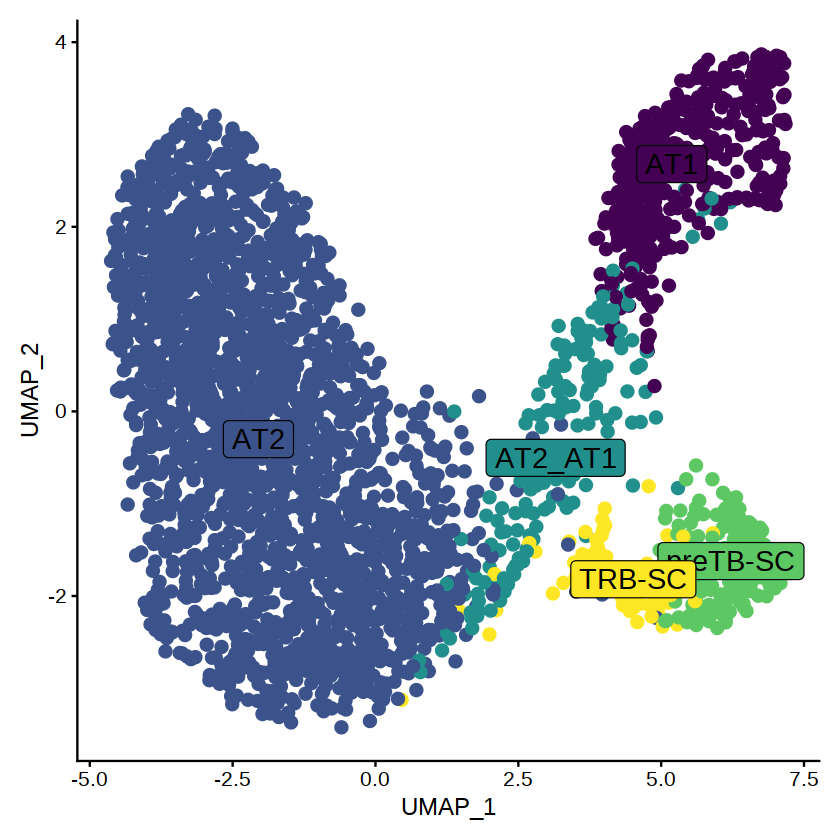

In [3]:
immune <- readRDS('epi_lung.rds')
# pdf('./figures/AT_CellType.pdf', width = 5, height = 5)
immune@meta.data$AT_CellType <- factor(immune@meta.data$AT_CellType, levels = c('AT1', 'AT2', 'AT2_AT1', 'preTB-SC', 'TRB-SC'))
Idents(immune) <- "AT_CellType"
DimPlot(immune, reduction = "umap", label = TRUE, label.size = 6, label.box = TRUE, raster = FALSE, cols = viridis(5, option = "D"), pt.size = 3)+NoLegend()
# dev.off()
# pdf('./figures/AT_CellType.pdf', width = 5, height = 5)
# Idents(immune) <- "AT_CellType"
# DimPlot(immune, reduction = "umap", label = TRUE, label.size = 6, label.box = TRUE, raster = FALSE, cols = viridis(5, option = "D"), pt.size = 3)+NoLegend()
# dev.off()

In [3]:
# --- Epithelial_Top_Genes.csv
# DefaultAssay(immune) <- "RNA"
# Idents(immune) <- "AT_CellType"
# markers <- FindAllMarkers(immune, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# write.csv(markers, file="SubCellType_Top_Genes.csv")

In [16]:
immune.cluster <- subset(immune, Cohort %in% c('ev', 'paul'))
DefaultAssay(immune.cluster) <- 'RNA'
ct.list = immune.cluster@meta.data$AT_CellType %>% unique()
data <- NULL
for(ct in ct.list){
    immune.f <- subset(immune.cluster, AT_CellType == ct)
    cell.ssc <- immune.f@meta.data %>% subset(Group == 'SSC') %>% rownames()
    cell.hc <- immune.f@meta.data %>% subset(Group == 'HC') %>% rownames()
    diff <- FindMarkers(immune.f, min.pct = 0.01, logfc.threshold = 0.2, ident.1 = cell.ssc, ident.2 = cell.hc) %>% rownames_to_column(var = "gene")
    diff$AT_CellType <- ct
    data <- rbind(data, diff)
}
write.csv(data, 'DEGs_SScVSHC_ATCellType.csv')

In [3]:
# # --- Feature Plots
# pdf('./figures/replot_features.pdf', width = 4, height = 3)
# DefaultAssay(immune) <- "RNA"
# # FeaturePlot(immune, features=c('AGER'), raster = FALSE, order = TRUE, min.cutoff = 1, max.cutoff = 2, pt.size=1.5) 
# FeaturePlot(immune, features=c('SCGB3A2'), raster = FALSE, order = TRUE, min.cutoff = 3,  max.cutoff = 6, pt.size=1.5) 
# dev.off()

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


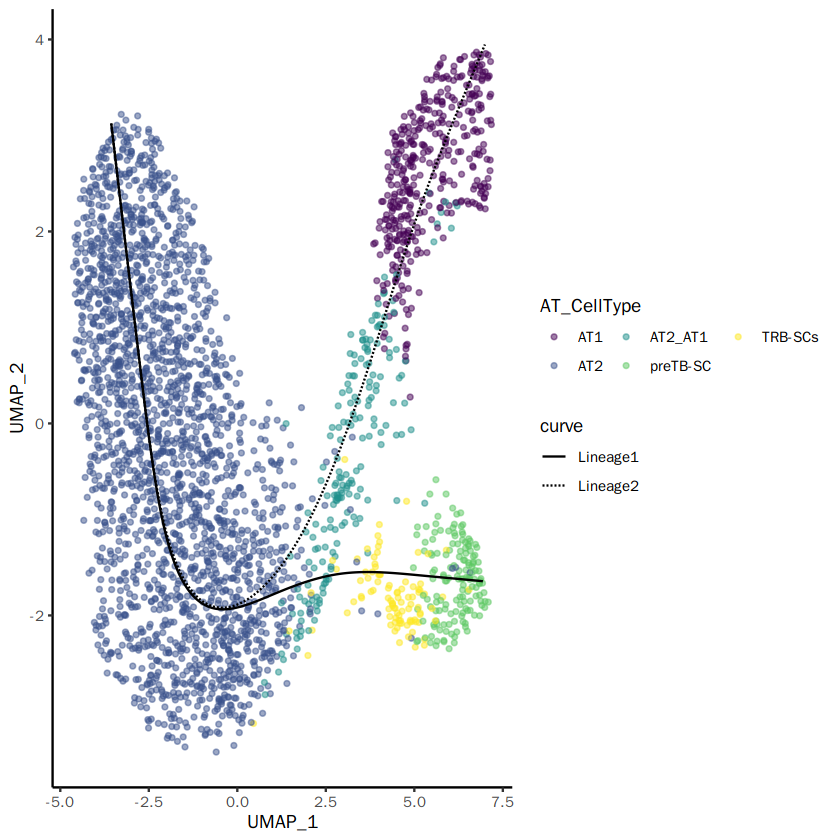

In [18]:
# --- Trajectory
# # --- monocle trajectory
# cds <- readRDS('monocle.rds')
# plot_cells(
#   cds,
#   x = 1,
#   y = 2,
#   reduction_method = "UMAP",
#   color_cells_by = "AT_CellType",
#   # group_cells_by = "CellType",
#   genes = NULL,
#   show_trajectory_graph = TRUE,
#   trajectory_graph_color = "black",
#   trajectory_graph_segment_size = 1,
#   norm_method = c("log", "size_only"),
#   label_cell_groups = FALSE, #TRUE:在图上标注出各个细胞群的名字，FALSE：以图例的形式标注出细胞群的名字。
#   label_groups_by_cluster = TRUE, #是否将细胞群的名字标注在每个细胞群落的中心
#   group_label_size = 1, #细胞群落名字的标签大小
#   labels_per_group = 1,
#   label_branch_points = FALSE,#标注出每一个节点的编号：黑色的圆圈显示
#   label_roots = TRUE,#标注出每一个根的标号
#   label_leaves = TRUE,#标注出每一个细胞群的编号，灰色的圆圈显示
#   graph_label_size = 3,#标注的大小
#   cell_size = 2,
#   # cell_stroke = I(cell_size/2),
#   alpha = 0.5,
#   min_expr = 0.1,
#   rasterize = TRUE,
#   scale_to_range = TRUE,
#   label_principal_points = TRUE #标注出分支的名字，方便后续选取分支进行深入分析
# )+scale_colour_manual(values = viridis(5, option = "D"))
# # ggsave('./figures/monocle.pdf',width = 8)

# --- Slingshot Trajectory
# immune <- readRDS('AT2_LQ_unfilter.rds')
plotPseudoTime(immune, group.by = "AT_CellType", reduction = "umap",dims = 1:2, pt.size=1, pt.alpha = 0.5,
               colors = viridis(5, option = "D")) + theme_classic() 

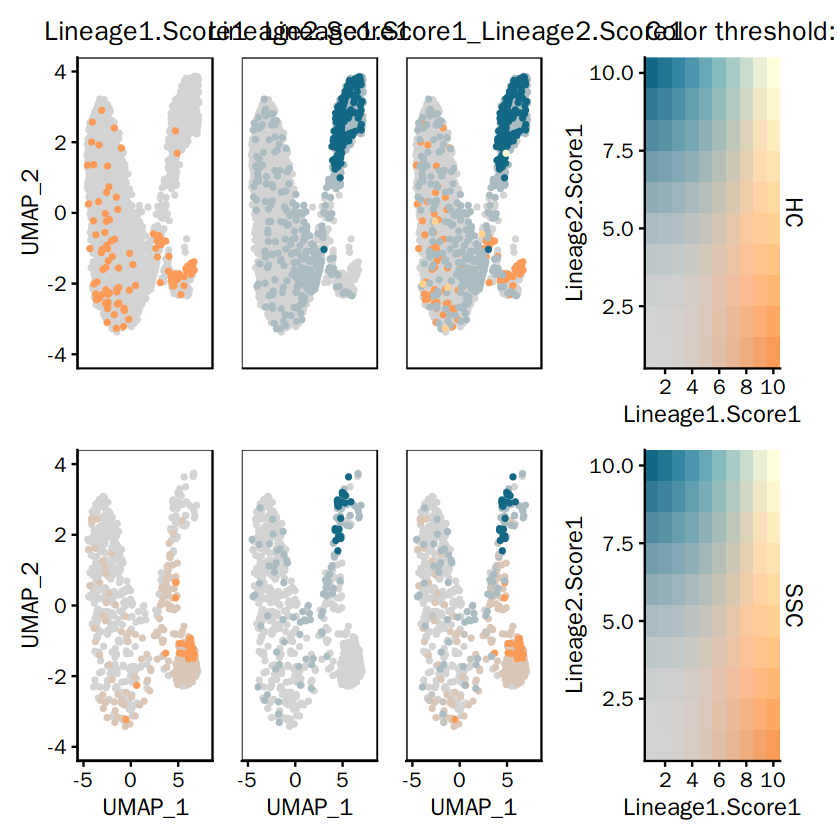

In [6]:
# # --- TradeSeq diffEndTest分数计算分化 module+绘制
# sce <- readRDS('tradeseq.rds')
# # Discovering differentiated cell type markers
# endRes <- diffEndTest(sce)
# end <- order(endRes$waldStat, decreasing = TRUE)
# data <- endRes %>% rownames_to_column(var='gene')
# data <- filter(data, pvalue < 0.001) 
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data <- data[order(-data[,2]),]
# data$`Rank_by_waldStat` <- 1:length(data[,2])
# endRes <- data
# write.csv(data,'endRES.csv')

# # immune.module <- immune
# l1.features <- (subset(endRes, logFC1_2 > 0 & pvalue < 0.001))$gene
# immune.module <- AddModuleScore(
#                  object = immune.module,
#                  features = list(l1.features),
#                  # ctrl = ceiling(length(lineage.features)/2),
#                  name = 'Lineage1.Score',
#                  assay = "RNA" )
# l2.features <- (subset(endRes, logFC1_2 < 0 & pvalue < 0.001))$gene
# immune.module <- AddModuleScore(
#                  object = immune.module,
#                  features = list(l2.features),
#                  # ctrl = ceiling(length(lineage.features)/2),
#                  name = 'Lineage2.Score',
#                  assay = "RNA" )
# saveRDS(immune.module, './all_assays_samples.rds')

DefaultAssay(immune) <- "RNA"
# pdf(file="./LineageScore.pdf", width=10,height=5)
FeaturePlot(immune, features=c("Lineage1.Score1", "Lineage2.Score1"), pt.size=1, blend = TRUE,
            cols = c("lightgrey","#FB9B57","#136885"),
            order = TRUE, split.by = 'Group', label.size=1)
# dev.off()

In [23]:
# --- 按分化轨迹计算 DEGs
# # Lineage1
# pseu.l <- subset(immune, Lineage1 != 'NA') %>% subset(Cohort != 'jxue')

# DefaultAssay(pseu.l) <- 'RNA'
# Idents(pseu.l) <- 'Group'
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l1_RNA.csv')


# DefaultAssay(pseu.l) <- 'TF'
# Idents(pseu.l) <- 'Group'
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25, pseudocount.use = 0.001,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l1_TF.csv')

# DefaultAssay(pseu.l) <- 'AUC'
# Idents(pseu.l) <- "Group"
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25, pseudocount.use = 0.001,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l1_AUC.csv')

# # Lineage2
# pseu.l <- subset(immune, Lineage2 != 'NA') %>% subset(Cohort != 'jxue')


# DefaultAssay(pseu.l) <- 'RNA'
# Idents(pseu.l) <- 'Group'
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l2_RNA.csv')


# DefaultAssay(pseu.l) <- 'TF'
# Idents(pseu.l) <- 'Group'
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25, pseudocount.use = 0.001,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l2_TF.csv')

# DefaultAssay(pseu.l) <- 'AUC'
# Idents(pseu.l) <- "Group"
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25, pseudocount.use = 0.001,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l2_AUC.csv')

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


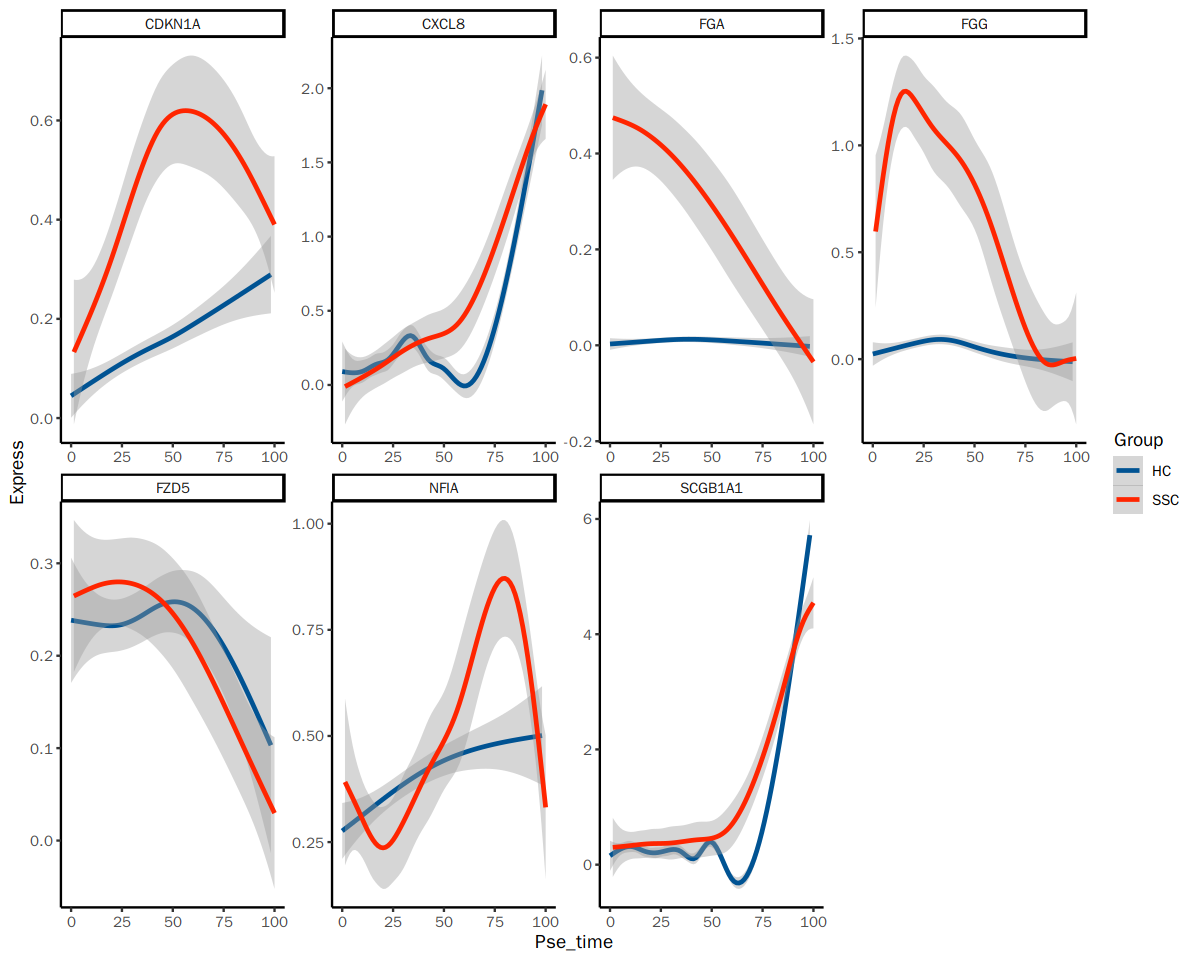

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


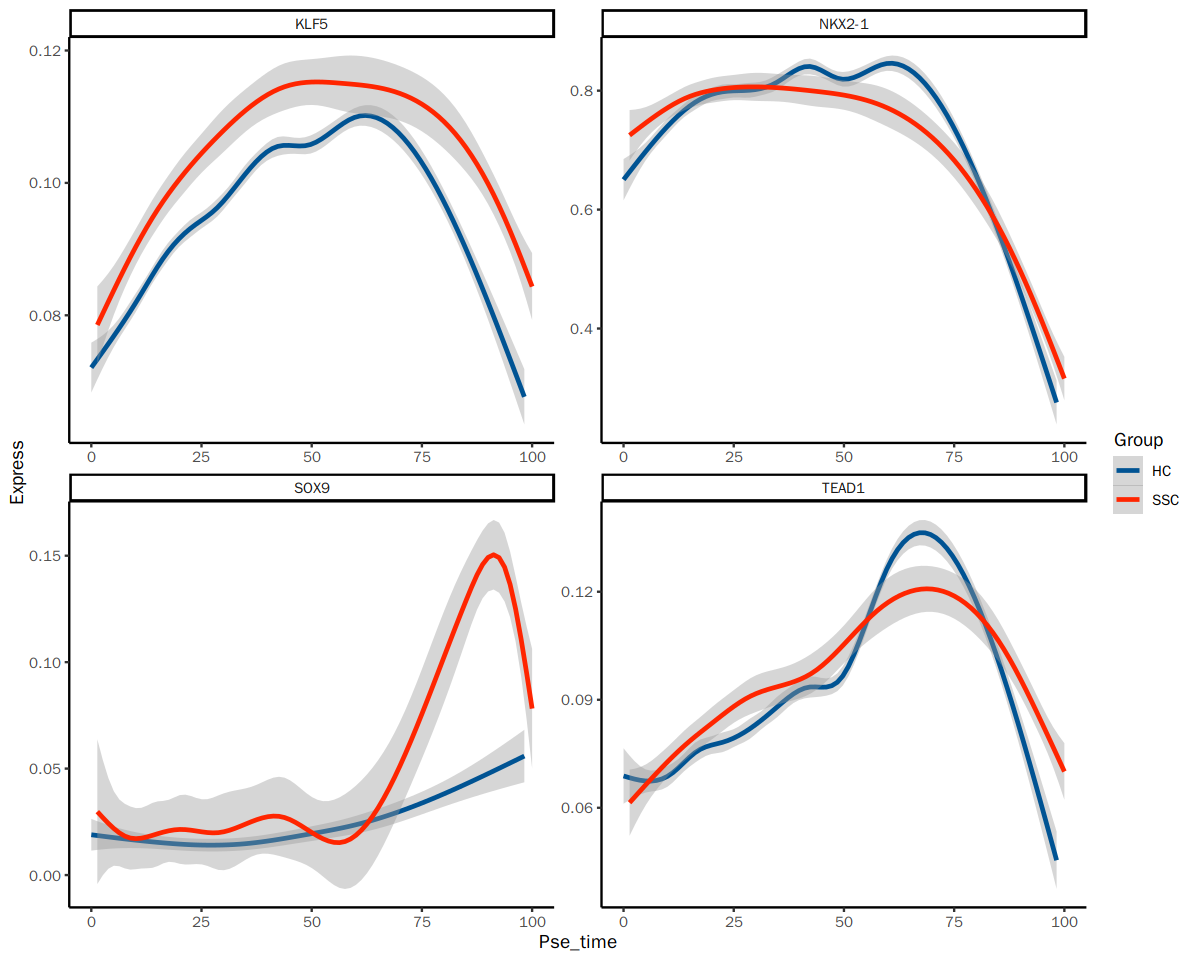

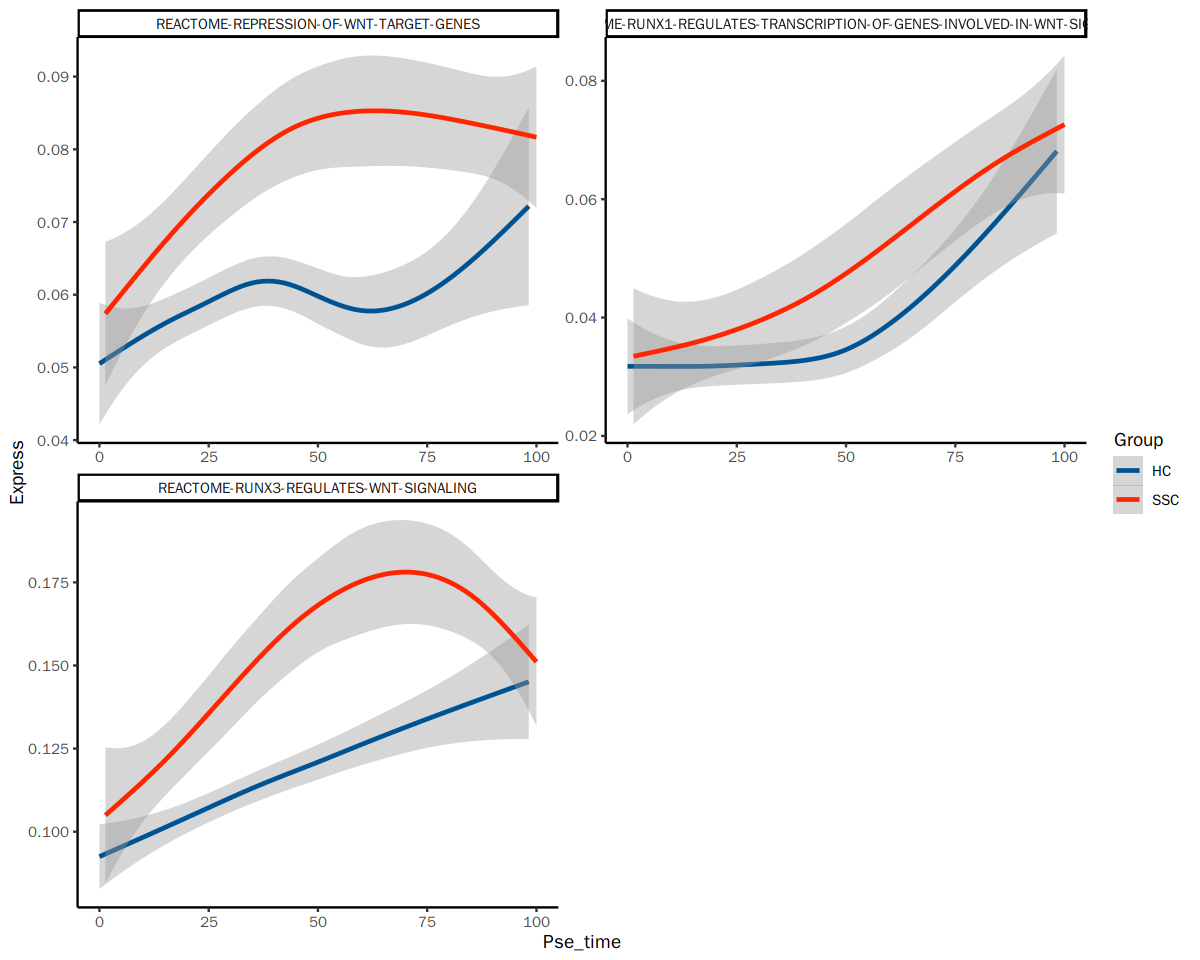

In [32]:
# --- 按 Lineage比较 SSC 和 HC 的基因表达
pseu.l <- subset(immune, Lineage1 != 'NA')
metadata <- pseu.l@meta.data %>% tibble::rownames_to_column(var='Cell') %>% 
                .[,c('Cell','Group','Lineage1_pct')]
# --- Genes
genes <- c(
'SCGB1A1',# TRB-SCs marker基因
    'CXCL8','CDKN1A',#衰老信号
    'FZD5','NFIA',
    'FGG','FGA'
)

gene.seurat <- pseu.l[['RNA']]@data[genes,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, by='Cell')  %>% 
                                    pivot_longer(!c(Cell,genes,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')


ggplot(data = gene.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=2, scales = 'free')
# ggsave('./figures/preTB-SC_RNA.pdf',width = 7, height = 3)

# --- Tfs
tfs <- c(
'SOX9',#预测的TRB-SCs 分化因子，的确在SSC中更多
    'TEAD1','NKX2-1',#促AT1分化的因子，在AT0阶段【60%-70%】表达不足
    'KLF5')

tf.seurat <- pseu.l[['TF']]@data[tfs,] %>% 
                as.matrix() %>%
                t() %>% 
                as.data.frame() %>% 
                tibble::rownames_to_column(var='Cell') %>% 
                left_join(metadata, by='Cell')  %>% 
                pivot_longer(!c(Cell,tfs,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')


ggplot(data = tf.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=2, scales = 'free')
# ggsave('./figures/preTB-SC_TF.pdf',width = 7, height = 6)

auc <- c('REACTOME-RUNX1-REGULATES-TRANSCRIPTION-OF-GENES-INVOLVED-IN-WNT-SIGNALING',
'REACTOME-RUNX3-REGULATES-WNT-SIGNALING',
'REACTOME-REPRESSION-OF-WNT-TARGET-GENES')

auc.seurat <- pseu.l[['AUC']]@data[auc,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, by='Cell') %>% 
                                    pivot_longer(!c(Cell, 'REACTOME-RUNX1-REGULATES-TRANSCRIPTION-OF-GENES-INVOLVED-IN-WNT-SIGNALING',
'REACTOME-RUNX3-REGULATES-WNT-SIGNALING',
'REACTOME-REPRESSION-OF-WNT-TARGET-GENES',Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

colnames(auc.seurat) <- gsub('[-]', '_', colnames(auc.seurat))
auc <- gsub('[-]', '_', auc)
ggplot(data = auc.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=2, scales = 'free')
# ggsave('./figures/L1_AUC.pdf',width = 15, height = 8)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 56 rows containing non-finite values (`stat_smooth()`).”


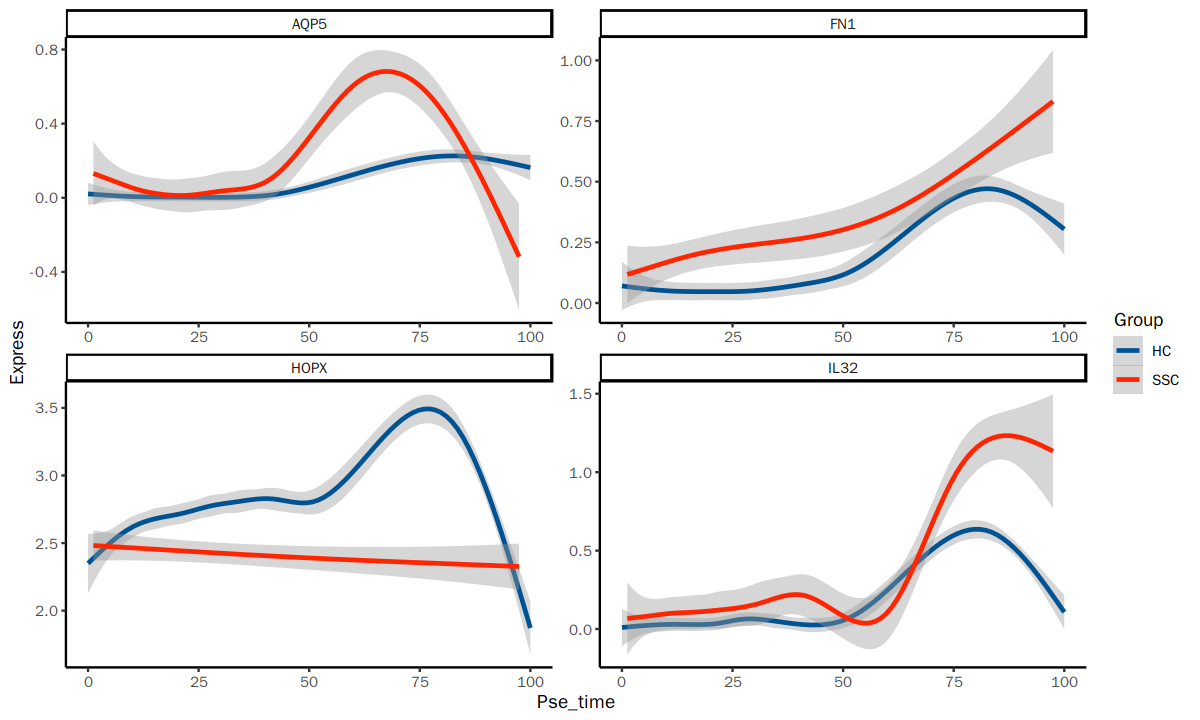

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


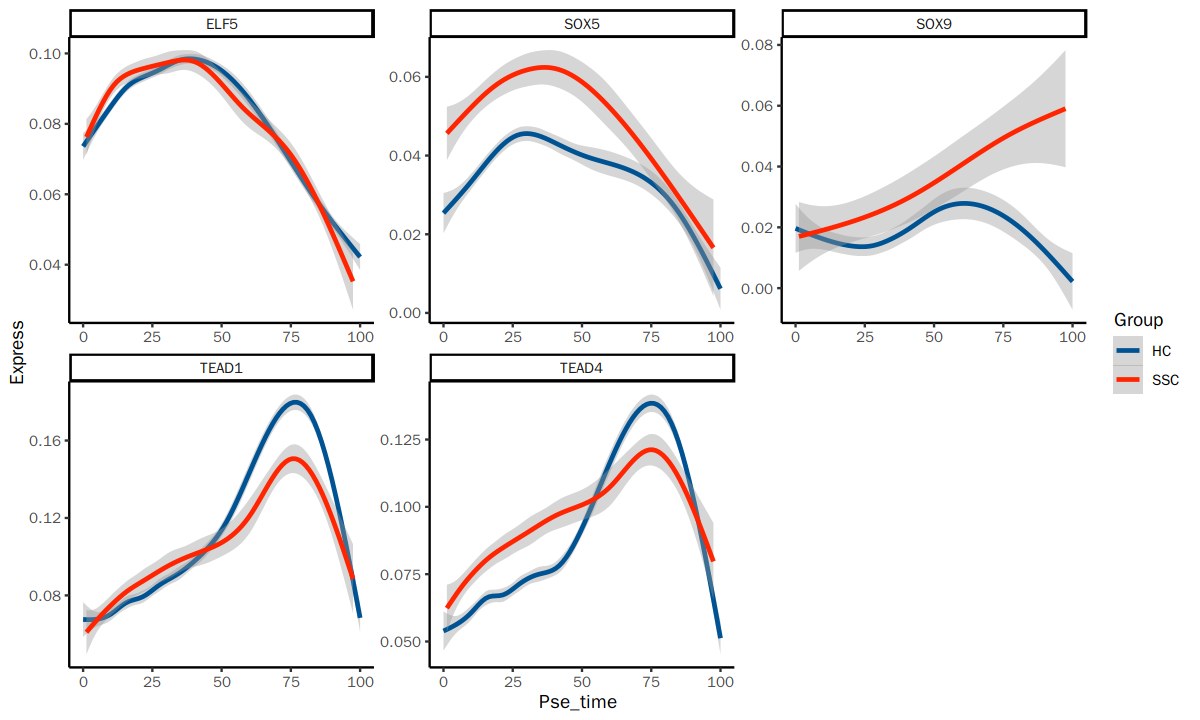

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


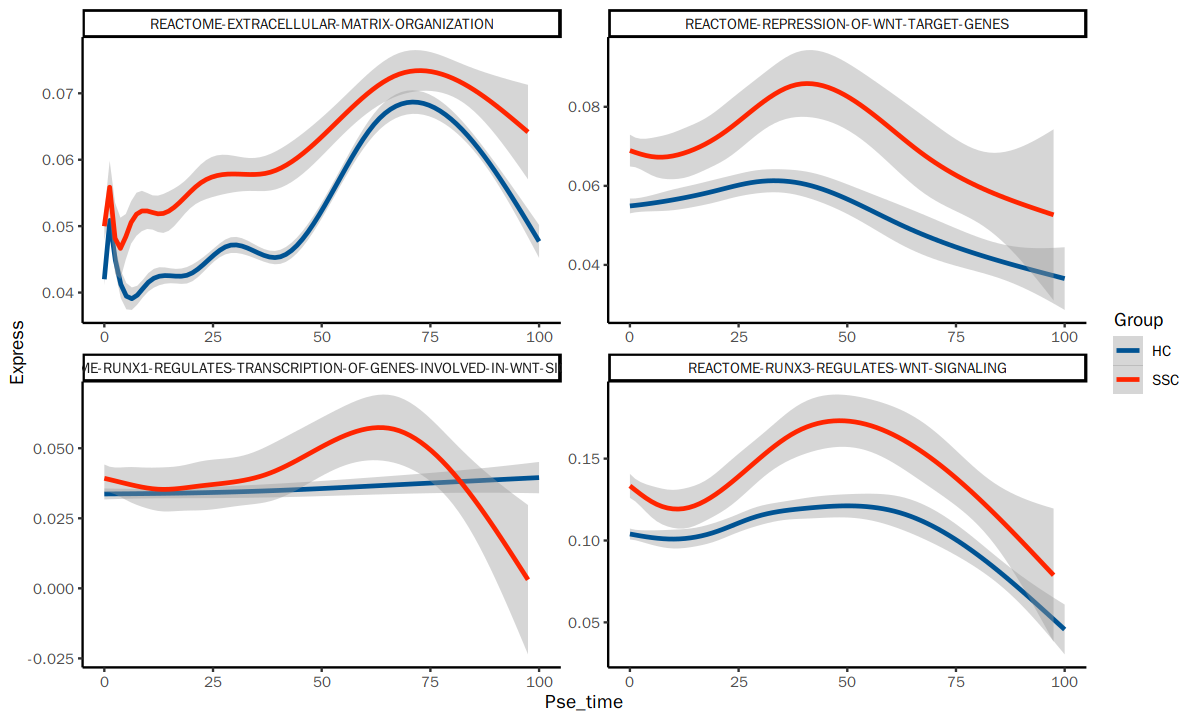

In [69]:
# --- 按 Lineage比较 SSC 和 HC 的基因表达
pseu.l <- subset(immune, Lineage2 != 'NA')
metadata <- pseu.l@meta.data %>% tibble::rownames_to_column(var='Cell') %>% 
                .[,c('Cell','Group','Lineage2_pct')]

genes <- c(
    'AQP5','HOPX','IL32', 'FN1'#Fibronectins
    #'COL1A1', 'COL1A2', 'COL2A1', 'COL4A1', 'COL4A2', 'COL3A1'
# 'CXCL2','AGER','FZD5','EGFR','CDKN1A','WNT3A','COL4A4','CYP1B1','CD74'
)

gene.seurat <- pseu.l[['RNA']]@data[genes,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, by='Cell')  %>% 
                                    pivot_longer(!c(Cell,genes,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

gene.seurat$Group <- factor(gene.seurat$Group, levels = c('HC','SSC'))
ggplot(data = gene.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=2, scales = 'free')
ggsave('./figures/AT1_RNA.pdf',width = 6, height = 6)

tfs <- c(
  'TEAD4','TEAD1',#AT1分化的趋化因子
    'SOX5' ,'SOX9' #
    ,'ELF5'
)
tf.seurat <- pseu.l[['TF']]@data[tfs,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, by='Cell') %>% 
                                    pivot_longer(!c(Cell,tfs,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

ggplot(data = tf.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=2, scales = 'free')
# ggsave('./figures/L2_TF.pdf',width = 7, height = 6)

auc <- c('REACTOME-RUNX1-REGULATES-TRANSCRIPTION-OF-GENES-INVOLVED-IN-WNT-SIGNALING',
         'REACTOME-RUNX3-REGULATES-WNT-SIGNALING',
         'REACTOME-REPRESSION-OF-WNT-TARGET-GENES',
         'REACTOME-EXTRACELLULAR-MATRIX-ORGANIZATION',
         'REACTOME-FIBRONECTIN-MATRIX-FORMATION')

auc.seurat <- pseu.l[['AUC']]@data[auc,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, by='Cell') %>% 
                                    pivot_longer(!c(Cell, 'REACTOME-RUNX1-REGULATES-TRANSCRIPTION-OF-GENES-INVOLVED-IN-WNT-SIGNALING',
'REACTOME-RUNX3-REGULATES-WNT-SIGNALING', 'REACTOME-EXTRACELLULAR-MATRIX-ORGANIZATION', #'REACTOME-FIBRONECTIN-MATRIX-FORMATION',
'REACTOME-REPRESSION-OF-WNT-TARGET-GENES',Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

colnames(auc.seurat) <- gsub('[-]', '_', colnames(auc.seurat))
auc <- gsub('[-]', '_', auc)
ggplot(data = auc.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=2, scales = 'free')
ggsave('./figures/AT1_AUC.pdf',width = 15, height = 8)

In [4]:
# --- tradeseq
library(tradeSeq)
library(RColorBrewer)
library(SingleCellExperiment)
library(magrittr)
library(slingshot)
library(mclust, quietly = TRUE)
library(mgcv)
immune.cluster <- readRDS('./AT2_LQ_sling.rds')
immune.cluster.l1 <- subset(immune.cluster, Lineage1 != 'NA')

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:IRanges’:

    collapse


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.


Attaching package: ‘mgcv’


The following object is masked from ‘package:mclust’:

    mvn




In [7]:
# # Lineage1
# immune.cluster.l1 <- subset(immune.cluster, Lineage1 != 'NA')
# DefaultAssay(immune.cluster.l1) <- "RNA"
# immune.cluster.l1 <- FindVariableFeatures(immune.cluster.l1, selection.method = "vst", nfeatures = 5000)
# features  <- VariableFeatures(immune.cluster.l1)
# mt <- grep(pattern="^MT-", x=features, value = T)
# ribo <- grep(pattern="^RP[SL]", x=features, value = T)
# features <- features[! features %in% c(mt, ribo)]
# length(features)

# counts1 <- GetAssayData(immune.cluster.l1, assay = 'RNA', slot = 'counts')
# counts1 <- counts1[features,]


# cellweights1 <- slingCurveWeights(immune.cluster.l1@misc[['slingshot']]$data) %>%
#                 as.data.frame() %>%
#                 rownames_to_column(var='cell') %>%
#                 .[,c(1,3)] %>%
#                 filter(cell %in% (colnames(counts2)))%>%
#                 tibble::column_to_rownames(var='cell') %>%
#                 as.matrix()


# pseudotimes1 <- slingPseudotime(SlingshotDataSet(immune.cluster.l1@misc[['slingshot']]$data), na = FALSE) %>%
#                 as.data.frame() %>%
#                 rownames_to_column(var='cell') %>%
#                 .[,c(1,3)] %>%
#                 filter(cell %in% (colnames(counts2)))%>%
#                 tibble::column_to_rownames(var='cell') %>%
#                 as.matrix()

# sce1 <- fitGAM(counts = counts1, pseudotime = pseudotimes1, cellWeights = cellweights1, conditions = factor(immune.cluster.l1@meta.data$Group))
# saveRDS(sce1,'./l1_tradeseq.rds')

# sce.l1 <- readRDS('l1_tradeseq.rds')
# condRes1 <- conditionTest(sce.l1, l1fc = log2(1.5))
# fig.size(5,8)
# df <- condRes1 %>% 
#             rownames_to_column(var='gene') %>% 
#             filter(pvalue < 0.001) %>% 
#             .[order(-.[,2]),] 
# write.csv(df, './AT2_AT2_tradeseq_genes.csv')

# # --- plot gene ranks
# data <- condRes1 %>% 
#             rownames_to_column(var='gene') %>% 
#             filter(pvalue < 0.001) %>% 
#             .[order(-.[,Lineage1]),] %>%
#             mutate(Rank_by_waldStat = 1:length(.[,2]))
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data$gene[which(data$pvalue != 1.0e-16)] <- NA
# ggplot(data) + 
#     geom_point(mapping=aes(x = Rank_by_waldStat, y = waldStat, colour = (-log10(pvalue)))) + 
#     geom_text_repel(#data %>% filter(pvalue == 1.0e-16),
#         label=data$gene,x=data$Rank_by_waldStat, y = data$waldStat, max.overlaps = getOption("ggrepel.max.overlaps", default = 20)) +
#     scale_color_distiller(palette = "RdBu") +
#     theme_bw()

In [8]:
# # Lineage2
# immune.cluster.l2 <- subset(immune.cluster, Lineage2 != 'NA')
# DefaultAssay(immune.cluster.l2) <- "RNA"
# immune.cluster.l2 <- FindVariableFeatures(immune.cluster.l2, selection.method = "vst", nfeatures = 5000)
# features  <- VariableFeatures(immune.cluster.l2)
# mt <- grep(pattern="^MT-", x=features, value = T)
# ribo <- grep(pattern="^RP[SL]", x=features, value = T)
# features <- features[! features %in% c(mt, ribo)]
# length(features)

# counts2 <- GetAssayData(immune.cluster.l2, assay = 'RNA', slot = 'counts')
# counts2 <- counts2[features,]


# cellweights2 <- slingCurveWeights(immune.cluster.l2@misc[['slingshot']]$data) %>%
#                 as.data.frame() %>%
#                 rownames_to_column(var='cell') %>%
#                 .[,c(1,3)] %>%
#                 filter(cell %in% (colnames(counts2)))%>%
#                 tibble::column_to_rownames(var='cell') %>%
#                 as.matrix()


# pseudotimes2 <- slingPseudotime(SlingshotDataSet(immune.cluster.l2@misc[['slingshot']]$data), na = FALSE) %>%
#                 as.data.frame() %>%
#                 rownames_to_column(var='cell') %>%
#                 .[,c(1,3)] %>%
#                 filter(cell %in% (colnames(counts2)))%>%
#                 tibble::column_to_rownames(var='cell') %>%
#                 as.matrix()

# sce2 <- fitGAM(counts = counts2, pseudotime = pseudotimes2, cellWeights = cellweights2, conditions = factor(immune.cluster.l2@meta.data$Group))
# saveRDS(sce2,'./l2_tradeseq.rds')

# sce.l2 <- readRDS('l2_tradeseq.rds')
# condRes1 <- conditionTest(sce.l2, l2fc = log2(1.5))
# fig.size(5,8)
# df <- condRes1 %>% 
#             rownames_to_column(var='gene') %>% 
#             filter(pvalue < 0.001) %>% 
#             .[order(-.[,2]),] 
# write.csv(df, './AT2_AT2_tradeseq_genes.csv')

# --- plot gene ranks
# data <- condRes1 %>% 
#             rownames_to_column(var='gene') %>% 
#             filter(pvalue < 0.001) %>% 
#             .[order(-.[,2]),] %>%
#             mutate(Rank_by_waldStat = 1:length(.[,2]))
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data$gene[which(data$pvalue != 1.0e-16)] <- NA
# ggplot(data) + 
#     geom_point(mapping=aes(x = Rank_by_waldStat, y = waldStat, colour = (-log10(pvalue)))) + 
#     geom_text_repel(#data %>% filter(pvalue == 1.0e-16),
#         label=data$gene,x=data$Rank_by_waldStat, y = data$waldStat, max.overlaps = getOption("ggrepel.max.overlaps", default = 20)) +
#     scale_color_distiller(palette = "RdBu") +
#     theme_bw()

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 5005 rows containing non-finite values (`stat_smooth()`).”
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 2860 rows containing non-finite values (`stat_smooth()`).”


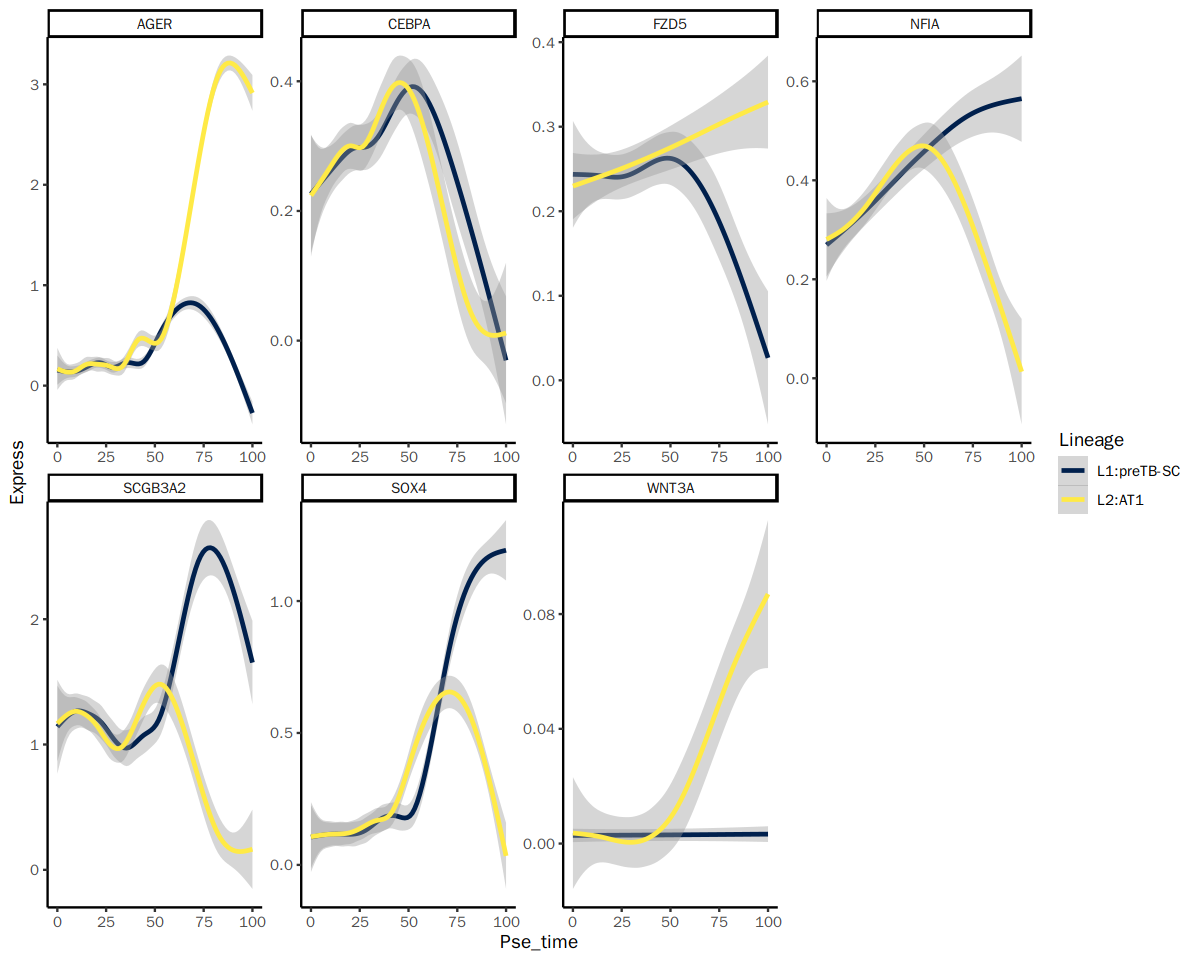

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 2145 rows containing non-finite values (`stat_smooth()`).”


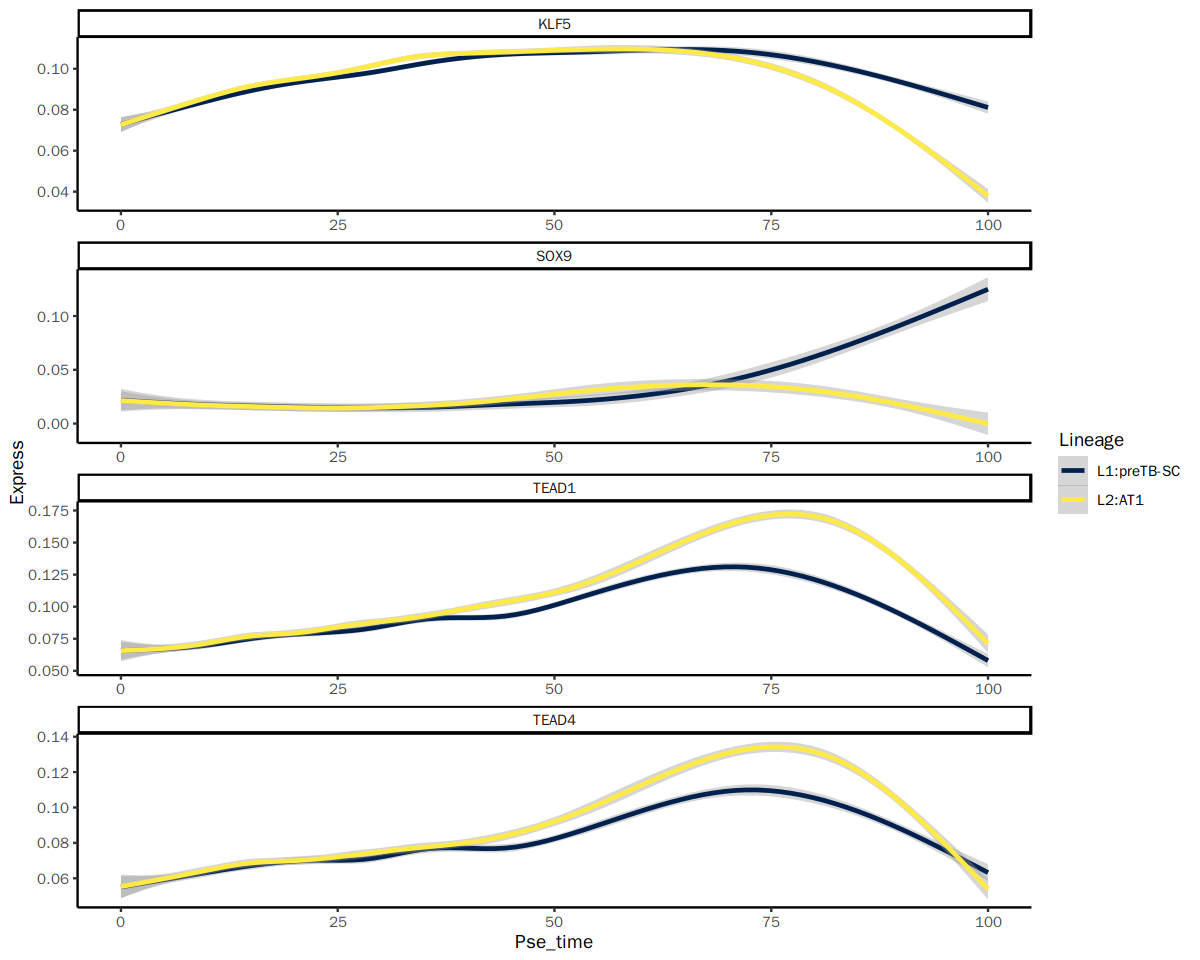

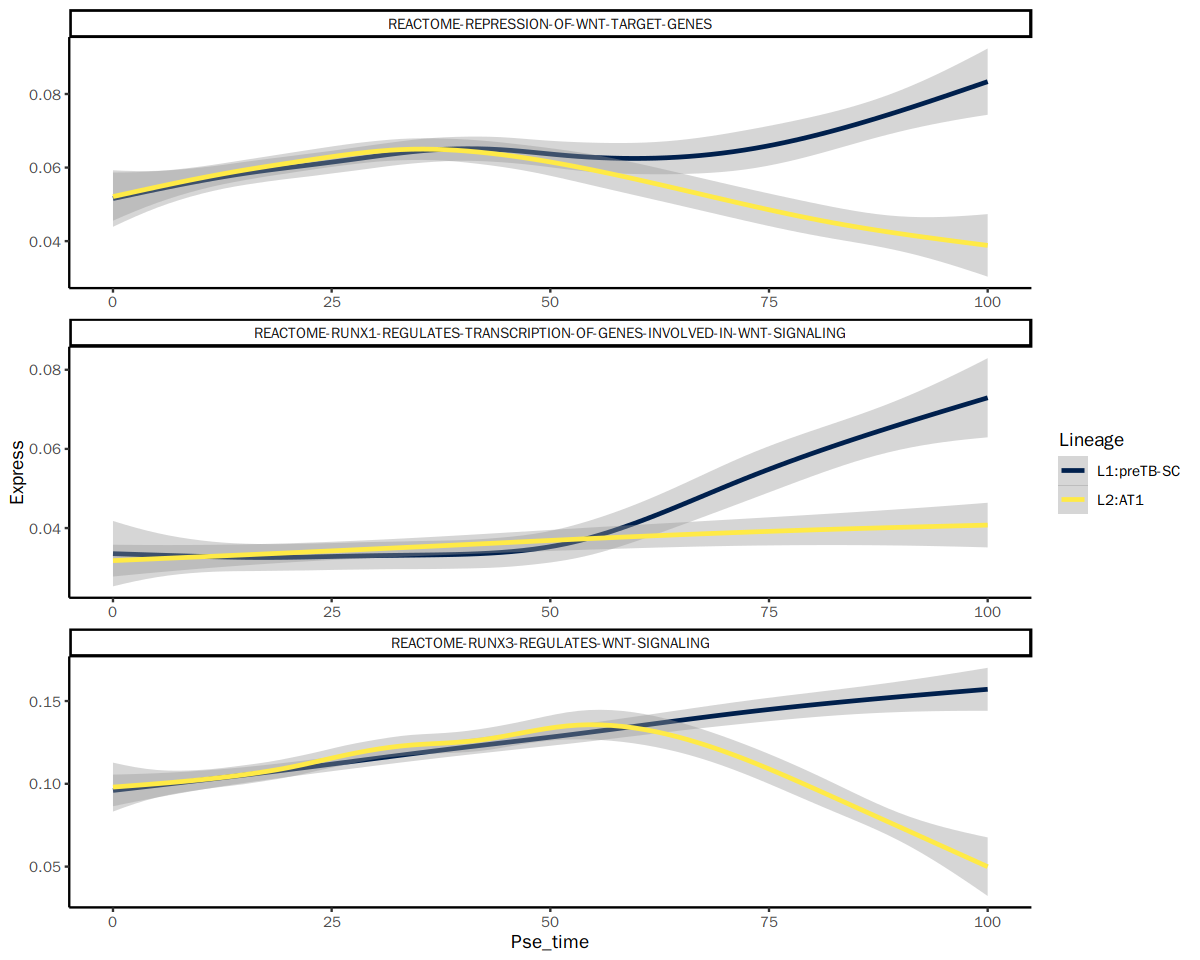

In [28]:
# --- 比较不同分化轨迹上 Mark基因的表达
fig.size(8,10)
metadata <-immune@meta.data %>% tibble::rownames_to_column(var='Cell') %>% 
                .[,c('Cell','Group','Lineage1_pct','Lineage2_pct')] 
colnames(metadata) <- c('Cell','Group','L1:preTB-SC','L2:AT1')

# --- genes
genes <- c(
    'AGER','SCGB3A2',#cell marker
    'FZD5','WNT3A',#wnt-fzd通路，促进AT2的分化
    # 'EGFR','EGF',# EGF的缺失会导致AT0向TRB-SCs分化
    'CEBPA','NFIA','SOX4'
)

gene.seurat <- immune[['RNA']]@data[genes,] %>% as.matrix() %>%
                                        t() %>% as.data.frame() %>% 
                                        tibble::rownames_to_column(var='Cell') %>%
                                        left_join(metadata, by='Cell')

data.seurat <- gene.seurat %>% 
                    pivot_longer(!c(Cell,genes
                   , Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

ggplot(data = data.seurat, aes(x=Pse_time, y=Express, group = Lineage, color=Lineage))+ 
  geom_smooth()+
  scale_colour_manual(values = viridis(2, option = "E"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=2, scales = 'free')
# ggsave('./figures/AT_RNA.pdf', width = 10, height = 6)

# --- TFs
tfs <- c(
'TEAD1','TEAD4',#AT1 分化途径的促分化因子
    'SOX9','KLF5'#促AT2干性分化，但是否促AT2-》TRB-SCs不知道
    # endRes$gene[1:10]
)
# Etv5, Sox9, Rbpj1 and Tfcp2l1

tfs.seurat <- immune[['TF']]@data[tfs,] %>% 
                t() %>% 
                as.data.frame() %>% 
                tibble::rownames_to_column(var='Cell') %>%
                left_join(metadata,by='Cell')

data.seurat <- tfs.seurat %>% 
    pivot_longer(!c(Cell, tfs
               ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

ggplot(data = data.seurat, aes(x=Pse_time, y=Express, group = Lineage, color=Lineage))+ 
  geom_smooth()+
  scale_colour_manual(values = viridis(2, option = "E"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=4, scales = 'free')
# ggsave('./figures/AT_TF.pdf', width = 7, height = 6)

auc <- c(
'REACTOME-RUNX1-REGULATES-TRANSCRIPTION-OF-GENES-INVOLVED-IN-WNT-SIGNALING',
'REACTOME-RUNX3-REGULATES-WNT-SIGNALING',
'REACTOME-REPRESSION-OF-WNT-TARGET-GENES'
)


auc.seurat <- immune[['AUC']]@data[auc,] %>% 
                t() %>% 
                as.data.frame() %>% 
                tibble::rownames_to_column(var='Cell') %>%
                left_join(metadata, by='Cell')

data.seurat <- auc.seurat %>% 
    pivot_longer(!c(Cell,'REACTOME-RUNX1-REGULATES-TRANSCRIPTION-OF-GENES-INVOLVED-IN-WNT-SIGNALING',
'REACTOME-RUNX3-REGULATES-WNT-SIGNALING',
'REACTOME-REPRESSION-OF-WNT-TARGET-GENES'
                    ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

ggplot(data = data.seurat, aes(x=Pse_time, y=Express, group = Lineage, color=Lineage))+ 
  geom_smooth()+
  scale_colour_manual(values = viridis(2, option = "E"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
# ggsave('./figures/AUC.pdf', width = 8, height = 10)

New names:
• `` -> `...1`
Rows: 1915 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): gene
dbl (6): ...1, waldStat, df, pvalue, logFC1_2, Rank_by_waldStat

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message:
“ggrepel: 1082 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message:
“ggrepel: 66 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


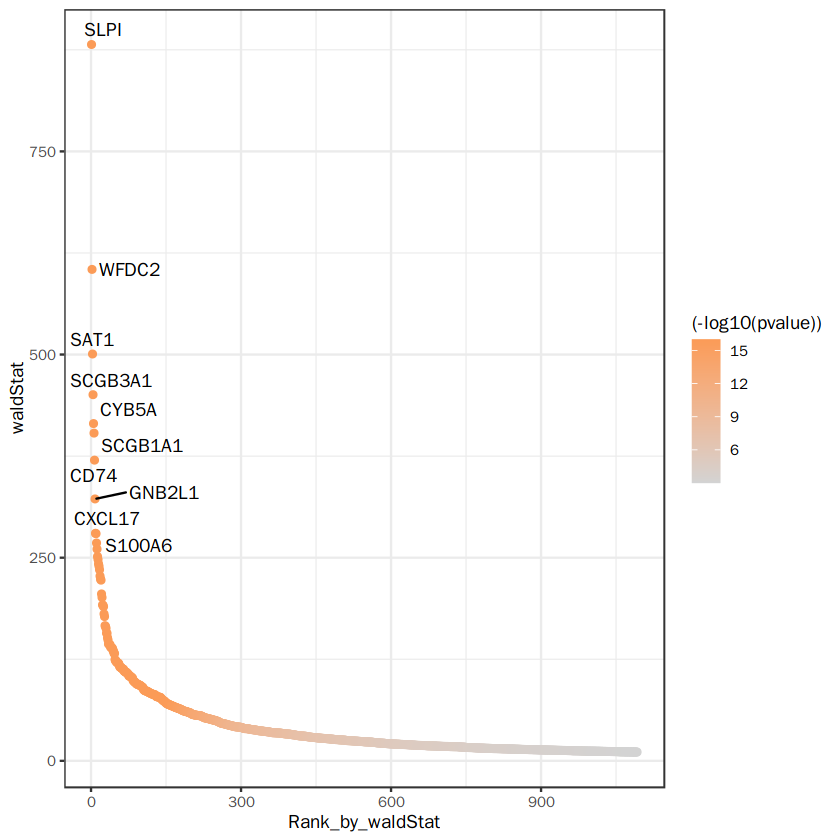

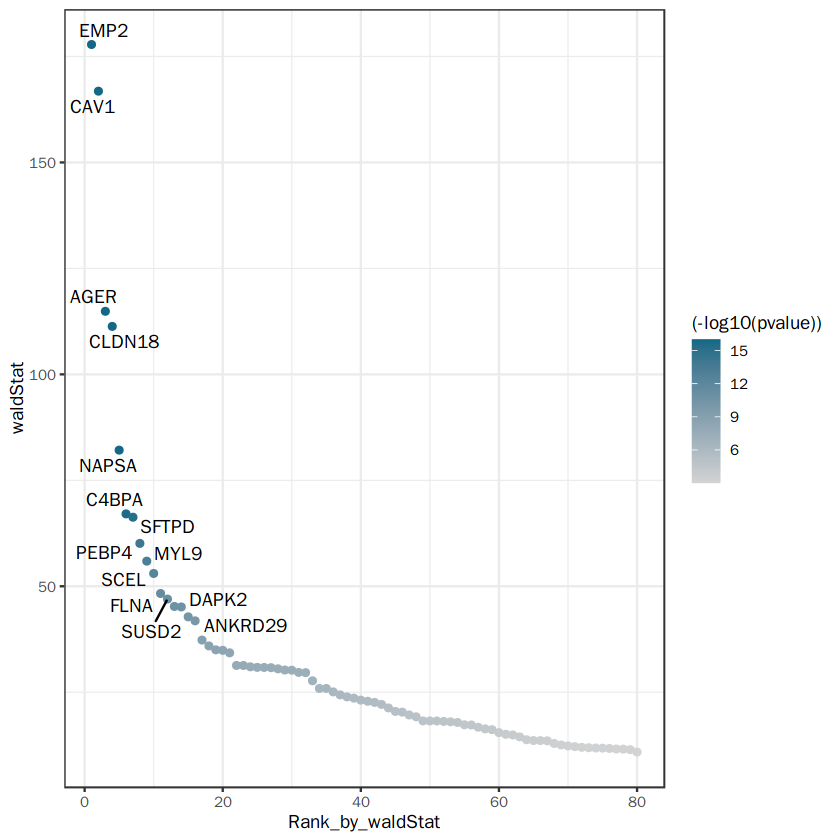

In [10]:
# --- endRES Features in each lineages
endRES <- read_csv('./endRES.csv')
gene.tb <- (subset(endRES, logFC1_2 > 0 & pvalue < 0.01)$gene)[1:100] #Lineage_TRB-SCs
gene.at1 <- subset(endRES, logFC1_2 < 0 & pvalue < 0.01)$gene #Lineage_AT1

data <- endRES[,2:6]
data <- filter(data, pvalue < 0.001,logFC1_2 > 0) 
data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
data <- data[order(-data[,2]),]
data$`Rank_by_waldStat` <- 1:length(data$gene)
ggplot(data) + 
    geom_point(mapping=aes(x = Rank_by_waldStat, y = waldStat, colour = (-log10(pvalue)))) + 
    geom_text_repel(label=data$gene,x=data$Rank_by_waldStat, y = data$waldStat) +
    scale_color_gradient(low="lightgrey",high = "#FB9B57")+
    theme_bw()
# ggsave('./figures/L1_pattern_wald.pdf',heigh=5,width = 8)
# "#FB9B57","#136885"

data <- endRES[,2:6]
data <- filter(data, pvalue < 0.001,logFC1_2 < 0) 
data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
data <- data[order(-data[,2]),]
data$`Rank_by_waldStat` <- 1:length(data$gene)
ggplot(data) + 
    geom_point(mapping=aes(x = Rank_by_waldStat, y = waldStat, colour = (-log10(pvalue)))) + 
    geom_text_repel(label=data$gene,x=data$Rank_by_waldStat, y = data$waldStat) +
    scale_color_gradient(low="lightgrey",high = "#136885")+
    # scale_color_viridis(begin=1,end=0,option="A")+
    theme_bw()
# ggsave('./figures/L2_pattern_wald.pdf',heigh=5,width = 8)

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] 406

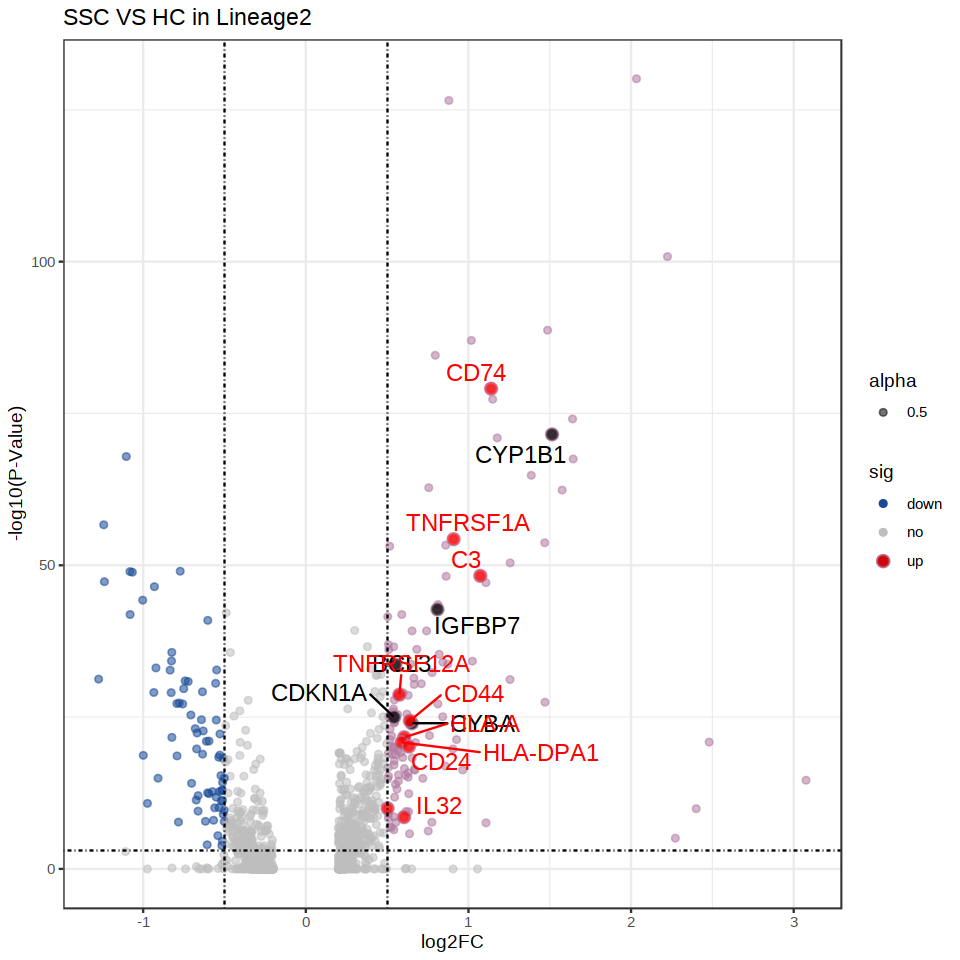

Warning message in diff$value[diff$gene %in% c(deg.up, deg.down)] <- diff$avg_log2FC:
“number of items to replace is not a multiple of replacement length”
Warning message in fgsea(fgsea_rec_sets, stats = ranks, nperm = 1000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”


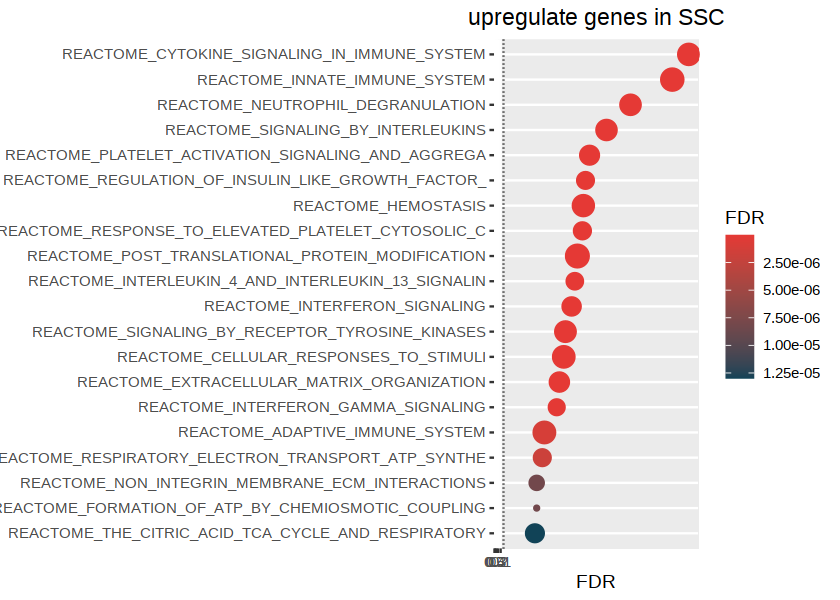

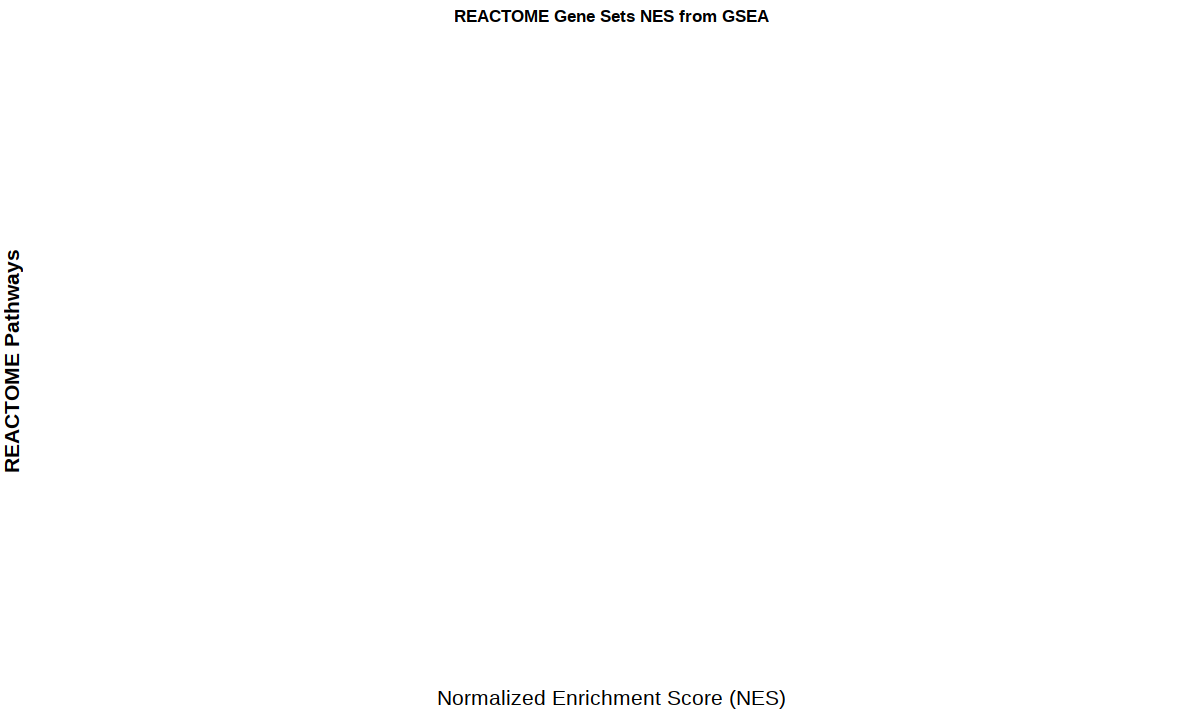

In [10]:
# --- DEGs: SSC VS HC in Lineage2 (AT1)
immune.f <- subset(immune, Lineage2_pct != 'NA')
cell.ssc <- immune.f@meta.data %>% subset(Group == 'SSC') %>% rownames()
cell.hc <- immune.f@meta.data %>% subset(Group == 'HC') %>% rownames()
DefaultAssay(immune.f) <- 'RNA'
diff <- FindMarkers(immune.f, min.pct = 0.01, logfc.threshold = 0.2, ident.1 = cell.ssc, ident.2 = cell.hc) %>% rownames_to_column(var = "gene")
write.csv(diff, 'Figures2.m.csv', row.names = F)
# --- plot
logFC <- diff$avg_log2FC
padj <- diff$p_val_adj
label <- diff$gene
data <- data.frame(logFC=logFC,padj=padj, label=label)
data$padj[data$padj == 0] <- 1e-300
data$sig[(data$padj > 0.001|data$padj=="NA")|(data$logFC < 0.5) & data$logFC > -0.5] <- "no"
data$sig[data$padj <= 0.001 & data$logFC >= 0.5] <- "up"
data$sig[data$padj <= 0.001 & data$logFC <= -0.5] <- "down"
mt.genes <- grep('^MT', diff$gene, value=T)
rp.genes <- grep('^RP[L/S]', diff$gene, value=T)
uk.genes <- grep('[.]', diff$gene, value=T)
data$label[which(data$sig == 'no')] <- ''
data$label[which(data$label %in% c(mt.genes, rp.genes, uk.genes))] <- ''

apop.genes = c('CYP1B1', 'CYBA', 'CDKN1A', 'BCL3', 'IGFBP7')
data$label_apop = ''
data$label_apop[data$label %in% apop.genes] <- data$label[data$label %in% apop.genes]
data$label[data$label %in% apop.genes] <- ''
data_apop <- data %>% dplyr::filter(label_apop != '')

data$label_inflam = ''
inflam.genes = c('CD74', 'C3', 'TNFRSF1A', 'TNFRSF12A', 'CD44', 'HLA-A', 'HLA-DPA1', 'CD24', 'HLA-DRB1', 'IL32')
data$label_inflam[data$label %in% inflam.genes] <- data$label[data$label %in% inflam.genes]
data$label[data$label %in% inflam.genes] <- ''
data_inflam <- data %>% dplyr::filter(label_inflam != '')

options(repr.plot.height = 8, repr.plot.width = 8)
ggplot(data ,aes(logFC,-1*log10(padj), color = sig, alpha = 0.5))+ 
    geom_point() +
    geom_point(data = data_apop, aes(logFC, -1 * log10(padj)), size = 3, alpha = 0.75, shape = 21, fill = 'black') +
    geom_point(data = data_inflam, aes(logFC, -1 * log10(padj)), size = 3, alpha = 0.75, shape = 21, fill = 'red') +
    labs(x="log2FC",y="-log10(P-Value)")+
    scale_color_manual(values =c("#184995","grey","#B17AA1"))+  
    geom_hline(yintercept=-log10(0.001),linetype=4)+
    geom_vline(xintercept=c(-0.5,0.5),linetype=4)+ 
    # geom_text_repel(label=data$label,size = 5, max.overlaps = 10)+
    geom_text_repel(label=data$label_apop, size = 5, color = 'black', alpha = 1, max.overlaps = 50) +
    geom_text_repel(label=data$label_inflam, size = 5, color = 'red', alpha = 1, max.overlaps = 50) +
    theme_bw() +
    ggtitle('SSC VS HC in Lineage2')
# ggsave('./figures/Lineage2_DEGs.pdf', width = 7, height = 7)

# --- Direct influence - pathway enrichment
# --- genes for directly influence
deg.up <- diff %>% dplyr::filter(p_val_adj < 0.001 & avg_log2FC > 0) %>% pull(gene)
deg.up <- deg.up[!deg.up %in% c(uk.genes)] 
length(deg.up)

options(repr.plot.height = 5, repr.plot.width = 7)
c1.gene = deg.up
geneset  <- biosets[['REACTOME']]
if(length(geneset$genesets[duplicated(geneset$genesets)]) >0){geneset$genesets <- geneset$genesets[!duplicated(geneset$genesets)]}
hyp_obj <- hypeR(c1.gene, geneset,test="hypergeometric", background=30000, fdr = 0.1)
hyp_dots(hyp_obj, title = paste0('upregulate genes in SSC'), pval=0.001)
# ggsave('./figures/Lineage2_DEGs_Reactome.pdf', width = 8, height = 5)

deg.up <- diff %>% dplyr::filter(p_val_adj < 0.001 & avg_log2FC > 0) %>% pull(gene)
deg.down <- diff %>% dplyr::filter(p_val_adj < 0.001 & avg_log2FC < 0) %>% pull(gene)
# set.seed(13)
deg.null = diff %>% dplyr::filter(! gene %in% c(deg.up, deg.down)) %>% arrange(-avg_log2FC) %>% .[c(1:50, (3993-150):3993),] %>% pull(gene )#sample(diff$gene[! diff$gene %in% c(deg.up, deg.down)], 100)
diff$value = 0
diff$value[diff$gene %in% c(deg.up, deg.down)] <- diff$avg_log2FC
diff$value[diff$gene %in% c(uk.genes)] <- 0

ranks <- diff %>% dplyr::filter(gene %in% c(deg.up, deg.down, deg.null)) %>% .[,c('gene', 'value')] %>% deframe()
fgseaRes_rec <- fgsea(fgsea_rec_sets, stats = ranks, nperm = 1000) %>% as.data.frame() %>% arrange(desc(NES)) 

options(repr.plot.height = 6, repr.plot.width = 10)
fgseaRes_rec %>% dplyr::filter(size >= 3 & pval < 0.001) %>%
  ggplot(aes(x = reorder(pathway, NES), y = NES, fill = NES)) +
  geom_col(width = 0.8, color = "white") +  # Narrow bar width for aesthetics
  scale_fill_gradient2(low = "#146eb4" , mid = "white", high = "firebrick", midpoint = 0) +  # Gradient fill for NES
  coord_flip() +
  labs(
    x = "REACTOME Pathways", 
    y = "Normalized Enrichment Score (NES)", 
    title = "REACTOME Gene Sets NES from GSEA",
    fill = "NES"
  ) +
  theme_minimal(base_size = 12) +  # Set a clean, minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, size = 10, face = "bold"),
    axis.text.x = element_text(size = 10, face = "bold", color = "grey30"),
    axis.text.y = element_text(size = 10, face = "bold", color = "grey30"),
    axis.title.y = element_text(vjust = 2, size = 12, face = "bold"),
    legend.position = "top",
    legend.title = element_text(size = 10),
    panel.grid.major.y = element_blank(),  # Remove horizontal grid for clarity
    panel.grid.minor = element_blank()
  )

In [28]:
#----------VlnFeaturePlot： hypoxia--------- 
options(repr.plot.height = 4, repr.plot.width = 6)
DefaultAssay(immune) <- 'RNA'
Idents(immune) <- 'Group'
immune@meta.data$AT_CellType <- factor(immune@meta.data$AT_CellType,
                                              levels = c('AT1', 'AT2', 'AT2_AT1', 'preTB-SC', 'TRB-SCs'))
pdf(file='./figures/Features_Vln_sup.pdf', width = 6, height = 3)
VlnPlot(immune.cluster, features = c( "HIF1A", "EPAS1", 'CDKN1A', 'IL32'), slot = "data", stack=TRUE, flip = T, adjust = 2, # CellFeatures:"IL1R1", "POSTN", "CXCL12", "FCN3", "EDNRB"
        cols =  c("#184995","#B17AA1"), split.by = 'Group', group.by = 'AT_CellType')
dev.off()

png 
  2

Warning message:
“Column annotation has different order from matrix columns. Adjust the
column annotation based on column names of the matrix.”


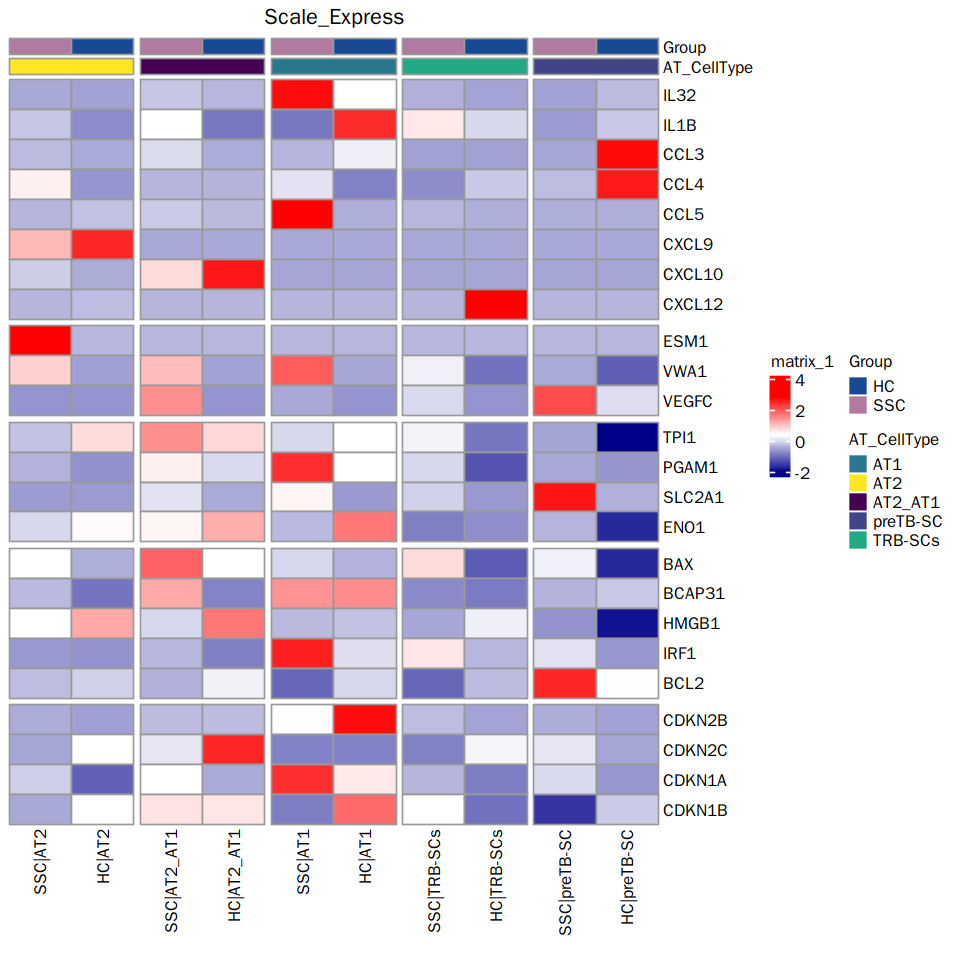

In [13]:
# --- HM：severarl pathway genes
options(repr.plot.height = 8, repr.plot.width = 8)
DefaultAssay(immune) <- 'RNA'
immune@meta.data$hm_group <- paste0(immune@meta.data$Group, '|', immune@meta.data$AT_CellType)
Idents(immune) <- 'hm_group'
immune@meta.data$hm_group <- factor(immune@meta.data$hm_group,
                                              levels = c('SSC|AT2', 'HC|AT2',
                                                         'SSC|AT2_AT1', 'HC|AT2_AT1',
                                                         'SSC|AT1', 'HC|AT1', 
                                                         'SSC|TRB-SCs', 'HC|TRB-SCs', 
                                                         'SSC|preTB-SC', 'HC|preTB-SC'))

infm.genes <- c('IL32','IL1B', 'CCL3','CCL4','CCL5','CXCL9','CXCL10','CXCL12') # inflammatory
angio.genes <- c('ESM1', 'VWA1', 'VEGFC') # angiogensis
hypo.genes <- c('TPI1', "PGAM1", "SLC2A1", "ENO1") %>% unique() # hypoxia & angiogensis
death.genes <- c('BAX', 'BCAP31', 'HMGB1',  'IRF1',  'BCL2') %>% unique() # programmed cell death
sene.genes <- c('CDKN2B', 'CDKN2C', 'CDKN1A', 'CDKN1B') #senescence
mrk.genes <- c(infm.genes, angio.genes, hypo.genes, death.genes, sene.genes)

sam.avg <- AverageExpression(immune, assays = 'RNA', group.by = 'hm_group')
hm.df <- sam.avg$RNA %>% t() %>% as.data.frame() %>% .[, mrk.genes] %>% scale(scale = TRUE, center = TRUE)

info <- immune@meta.data[, c('hm_group', 'Group', 'AT_CellType')] %>% unique() %>% {rownames(.) <- NULL; .} %>% column_to_rownames(var = 'hm_group') 

ann_colors=list(AT_CellType = c(`AT2` = '#FDE725FF', `AT2_AT1` = '#440154FF', AT1 = '#2A788EFF',  `TRB-SCs` = '#22A884FF', `preTB-SC` = '#414487FF'),
                Group = c(SSC = "#B17AA1", HC = "#184995"))
ct.list <- c('SSC|AT2', 'HC|AT2',
             'SSC|AT2_AT1', 'HC|AT2_AT1',
             'SSC|AT1', 'HC|AT1', 
             'SSC|TRB-SCs', 'HC|TRB-SCs', 
             'SSC|preTB-SC', 'HC|preTB-SC')
# pdf('./figures/HM_GeneExp_in_Groups.pdf', width = 10, height = 10)
hm <- pheatmap(hm.df[ct.list,] %>% t(), cluster_row = FALSE, cluster_col = FALSE, 
            color = c(colorRampPalette(colors = c("darkblue","white"))(50),colorRampPalette(colors = c("white", "red"))(50)), 
            main = ("Scale_Express"),
             annotation_col = info[,c('AT_CellType','Group')],
             annotation_colors = ann_colors,
             gaps_row = c(
                        length(infm.genes),
                        length(infm.genes) + length(angio.genes), 
                        length(c(infm.genes, angio.genes))+length(hypo.genes),
                        length(c(infm.genes, angio.genes, hypo.genes))+length(death.genes)),
            gaps_col = c(2,4,6,8,10)
            ) 
print(hm)
# dev.off()

In [64]:
# # --- Add annotations for a specific clustering
# immune@meta.data$AT_CellType <- as.character(immune@meta.data$AT_CellType)
# immune@meta.data$AT_CellType[which(immune@meta.data$AT_CellType == 'TRB-SCs')] <- 'TRB-SC'

# ct.res <- data.frame(AT_CellType = immune@meta.data$AT_CellType %>% as.character() %>% unique(),
#                      celltype.res.0.1 = 0:(length(immune@meta.data$AT_CellType %>% as.character() %>% unique()) - 1))
# meta <- immune@meta.data
# immune@meta.data <- meta %>% 
#                     rownames_to_column(var = 'barcode') %>%
#                     left_join(ct.res, by = 'AT_CellType') %>%
#                     column_to_rownames(var = 'barcode')

# immune@meta.data$Site[is.na(immune@meta.data$Site)] <- 'lung'
# immune@meta.data$Site[which(immune@meta.data$Site == 'UP')] <- 'lung_UP'
# immune@meta.data$Site[which(immune@meta.data$Site == 'LOW')] <- 'lung_LOW'
# immune@meta.data$Age[which(immune@meta.data$SamNum %in% c('SScJ1', 'SScJ2'))] <- 54

# DefaultAssay(immune) <- 'RNA'
# Idents(immune) <- 'celltype.res.0.1'
# markers <- FindAllMarkers(immune, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# saveRDS(markers, file = paste0('SnnGenes/ct_res.0.1.rds.gz'), compress = "gzip")

# saveRDS(immune, './epi_lung.rds')

In [62]:
immune@meta.data[,c('SamNum', 'Group', 'Site', 'Age', 'Gender', 'Cohort')] %>% distinct()

,SamNum,Group,Site,Age,Gender,Cohort
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
CONTROL 1_AACTCAGCACGGCTAC-1,CONTROL 1,HC,lung,55,Male,ev
CONTROL 2_AAGGCAGAGGGCATGT-1,CONTROL 2,HC,lung,57,Female,ev
CONTROL 3_AAACGGGAGATGTGTA-1,CONTROL 3,HC,lung,18,Male,ev
CONTROL 5_AAAGATGGTTAGTGGG-1,CONTROL 5,HC,lung_LOW,23,Female,ev
CONTROL 4_ACAGCCGTCATTGCCC-1,CONTROL 4,HC,lung_UP,23,Female,ev
SSC 2_AAAGTAGGTCATATCG-1,SSC 2,SSC,lung_UP,67,Female,ev
SSC 1_AAACGGGGTTGAGTTC-1,SSC 1,SSC,lung_LOW,67,Female,ev
SSC 4_AAGGCAGGTTGTTTGG-1,SSC 4,SSC,lung_UP,43,Male,ev
SSC 3_AACTCTTAGGGTCTCC-1,SSC 3,SSC,lung_LOW,43,Male,ev


In [65]:
# --- Create Scoupe_Loom file
library(SCopeLoomR)
library(hdf5r)
immune <- readRDS('./epi_lung.rds')
# --- 01 Create a loom file
build_loom(file.name = "immune.loom",
        dgem = immune@assays$RNA@counts,
        title = "epithelial",
        default.embedding = immune@reductions$umap@cell.embeddings,
        default.embedding.name = "umap.rna")

loom <- open_loom("immune.loom", mode = "r+")
# --- 02 Add hierachy
add_hierarchy(
  loom = loom,
  hierarchy = create_hierarchy(
    level.1.name = "SSc-ILD",
    level.2.name = "Lung-epithelial"
  )
)
# --- 03 Add embedding(s)
add_embedding(loom = loom, 
              embedding = immune@reductions$pca@cell.embeddings,
              name = "pca")

# --- 04 Add MetaDate
names(loom[["col_attrs"]])
add_col_attr(loom = loom, key = "Sample", value = immune@meta.data$SamNum, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Group", value = immune@meta.data$Group, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Site", value = immune@meta.data$Site, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Age", value = immune@meta.data$Age, as.metric = TRUE)
add_col_attr(loom = loom, key = "Gender", value = immune@meta.data$Gender, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Cohort", value = immune@meta.data$Cohort, as.annotation = TRUE)

immune@meta.data$AT_CellType <- as.character(immune@meta.data$AT_CellType)
add_col_attr(loom = loom, key = "CellType", value = immune@meta.data$AT_CellType, as.annotation = TRUE)

names(loom[["col_attrs"]])

# --- 05 Add Seurat clusters and markers
add_seurat_clustering(loom = loom,
        seurat = immune,
        seurat.assay = "RNA",
        seurat.clustering.prefix = "celltype.res.",
        seurat.markers.file.path.list = 
          list(celltype.res.0.1 = './SnnGenes/ct_res.0.1.rds.gz'),
        seurat.marker.metric.accessors = c("avg_log2FC", "p_val"),
        seurat.marker.metric.names = c("Avg. log2FC", "P-value"),
        seurat.marker.metric.description = c("Average log fold change", "Adjusted p-value (BF)")
)

# --- 06 save loom file
close_loom(loom)

[1] "Adding global attributes..."
[1] "Adding matrix..."
  |======================================================================| 100%[1] "Adding column attributes..."
[1] "Adding default metrics nUMI..."
[1] "Adding default metrics nGene..."
[1] "Adding default embedding..."
[1] "Adding row attributes..."
[1] "Adding columns graphs..."
[1] "Adding row graphs..."
[1] "Adding layers..."
[1] "Adding embedding pca..."


[1] "CellID"       "Embedding"    "Embeddings_X" "Embeddings_Y" "nGene"       
[6] "nUMI"

[1] "Age"          "CellID"       "CellType"     "Cohort"       "Embedding"   
 [6] "Embeddings_X" "Embeddings_Y" "Gender"       "Group"        "Sample"      
[11] "Site"         "nGene"        "nUMI"

[1] "Seurat, celltype.res.0.1"
[1] "Adding Seurat clusters..."
[1] "Clusterings created..."
[1] "Clustering ID: 0"
[1] "Adding Seurat markers..."
[1] "Adding markers for clustering 0..."
[1] "Adding metrics for clustering 0..."
